In [1]:
import numpy as np
import yt
import unyt
from yt import YTArray
from yt.data_objects.level_sets.api import Clump, find_clumps
import argparse
import os
from astropy.table import Table
from astropy.io import ascii
import multiprocessing as multi


import datetime
from scipy import interpolate
import shutil
import matplotlib.pyplot as plt
import cmasher as cmr
import matplotlib.colors as mcolors
import h5py
import trident

# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.get_run_loc_etc import get_run_loc_etc
from foggie.utils.yt_fields import *
from foggie.utils.foggie_load import *
from foggie.utils.analysis_utils import *

# These imports for datashader plots
import datashader as dshader
from datashader.utils import export_image
import datashader.transfer_functions as tf
import pandas as pd
import matplotlib as mpl
import numpy as np
from yt.units.yt_array import YTQuantity
from scipy.ndimage import gaussian_filter
import matplotlib.cm as mtcm
from matplotlib.colors import LogNorm


def generate_foggie_paths(halo, run, snap):
    # Define base paths
    foggie_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_data/"
    code_base_path = "/Users/vidasaeedzadeh/Projects/repositories/foggie/foggie/"
    output_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_outputs/"

    # Zero-pad the halo number to 6 digits
    halo_number = halo.zfill(6)

    # Define directory and file paths dynamically
    foggie_dir = os.path.join(foggie_base_dir, f"halo_{halo_number}", run + '/')
    snap_name = os.path.join(foggie_dir, snap, snap)
    halo_c_v_name = os.path.join(code_base_path, f"halo_infos/{halo_number}/{run}/halo_c_v")
    trackname = os.path.join(code_base_path, f"halo_tracks/{halo_number}/nref11n_selfshield_15/halo_track_200kpc_nref9")
    cloudy_path = code_base_path + "emission/cloudy_z0_selfshield/sh_z0_HM12_run%i.dat"
    #"emission/cloudy_z0_HM05/bertone_run%i.dat"
    #"emission/cloudy_z0_selfshield/sh_z0_HM12_run%i.dat"
    # Output directory (adjust based on needs)
    output_dir = output_base_dir

    # Return paths
    return foggie_dir,code_base_path, snap_name, halo_c_v_name, trackname, output_dir, cloudy_path

# specify halo and snapshot
halo = '8508'
run = 'ludicrous/nref13c_nref9f.enhance'
snap = 'DD2509'

foggie_dir,code_path, snap_name, halo_c_v_name, trackname, output_dir, cloudy_path = generate_foggie_paths(halo, run, snap)

prefix = output_dir + 'ions_halo_00' + halo + '/' + run + '/'
save_path = prefix + f'velocity_plots/'
os.makedirs(save_path, exist_ok=True)  # Ensure the directory exists

ds, refine_box = foggie_load(snap_name, trackname, do_filter_particles=True, halo_c_v_name=halo_c_v_name, disk_relative=True, correct_bulk_velocity=True)#, smooth_AM_name=smooth_AM_name)
zsnap = ds.get_parameter('CosmologyCurrentRedshift')
   


/Users/vidasaeedzadeh/miniforge3/envs/foggie/lib/python3.12/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
yt : [INFO     ] 2024-12-09 11:52:50,958 Parameters: current_time              = 638.06651531954
yt : [INFO     ] 2024-12-09 11:52:50,958 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-12-09 11:52:50,959 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-12-09 11:52:50,959 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-12-09 11:52:50,959 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-12-09 11:52:50,960 Parameters: current_redshift          = 0.0021037994044062
yt : [INFO     ] 2024-12-09 11:52:50,960 Parameters: omega_lambda              = 0.715
y

Opening snapshot /Users/vidasaeedzadeh/Projects/foggie_data/halo_008508/ludicrous/nref13c_nref9f.enhance/DD2509/DD2509
get_refine_box: using this location:        col1          col2     col3     col4     col5     col6     col7   col8
------------------ -------- -------- -------- -------- -------- -------- ----
0.0021111231691204 0.488873 0.470349 0.508524 0.490873 0.472349 0.510524    9


Parsing Hierarchy : 100%|██████████| 14472/14472 [00:00<00:00, 29336.69it/s]
yt : [INFO     ] 2024-12-09 11:52:51,729 Gathering a field list (this may take a moment.)


This halo_c_v file doesn't exist, calculating halo center...
get_halo_center: code_length code_velocity
get_halo_center: obtained the spherical region
get_halo_center: extracted the DM density
get_halo_center: we have obtained the preliminary center
got the velocities
get_halo_center: located the main halo at: [0.48985743522644043, 0.47122740745544434, 0.5095312595367432] [unyt_quantity(0.001008, 'code_velocity'), unyt_quantity(-0.00177564, 'code_velocity'), unyt_quantity(0.0011421, 'code_velocity')]
filtering young_stars particles...
filtering young_stars3 particles...
filtering young_stars8 particles...
filtering old_stars particles...
filtering stars particles...
filtering dm particles...
using particle type  young_stars  to derive angular momentum
found angular momentum vector


In [2]:
print("Domain Dimensions:", ds.domain_dimensions)
print("Domain Left Edge:", ds.domain_left_edge)
print("Domain Right Edge:", ds.domain_right_edge)

Domain Dimensions: [256 256 256]
Domain Left Edge: [0. 0. 0.] code_length
Domain Right Edge: [1. 1. 1.] code_length


In [ ]:
# make a covering grid that cover the refineed box

# data_sources = {'all': ds.all_data()}

# all_data_level_0 = ds.covering_grid(
#     level=0, left_edge=[0, 0.0, 0.0], dims=ds.domain_dimensions
    
# )

# print("Shape of the covering grid:", all_data_level_0["density"].shape)

Shape of the covering grid: (256, 256, 256)


In [ ]:
# Define the field to test
# field_to_test = ("gas", "density")  # Replace with your field name

# # Create a covering grid at level 0
# covering_grid = ds.covering_grid(
#     level=0, left_edge=ds.domain_left_edge, dims=ds.domain_dimensions
# )

# # Extract the data from the covering grid
# cg_density = covering_grid[field_to_test]

# # Extract level 0 data directly from the AMR hierarchy
# level_0_data = ds.index.select_grids(level=0)

# # Combine data from all level 0 grids
# level_0_density = np.concatenate([grid[field_to_test].flatten() for grid in level_0_data])

# # Check if the covering grid matches the level 0 data
# if np.allclose(cg_density.flatten(), level_0_density, rtol=1e-5):
#     print("Covering grid matches the level 0 AMR data!")
# else:
#     print("Mismatch found between covering grid and level 0 AMR data!")


Covering grid matches the level 0 AMR data!


In [66]:
# # Convert halo center to code_length
# halo_center = ds.halo_center_kpc.in_units("code_length")
# print(halo_center)

# # Step 1: Attach the unit of kpc to refine_width
# refine_width_kpc = YTQuantity(ds.refine_width, "kpc")

# # Step 2: Convert refine_width to code_length using the dataset's length unit factor
# refine_width_code_length = refine_width_kpc / ds.length_unit

# # Print the results for verification
# print("Refine width in kpc:", refine_width_kpc)
# print("Refine width in code_length:", refine_width_code_length)


# refine_width = refine_width_code_length

In [67]:
# from yt.units import YTQuantity

# # Step 1: Attach the unit of kpc to refine_width
# refine_width_kpc = YTQuantity(ds.refine_width, "kpc")

# # Step 2: Convert refine_width to code_length while retaining units
# refine_width_code_length = refine_width_kpc.to(ds.length_unit.units)

# # Print for verification
# print("Refine width in kpc:", refine_width_kpc)
# print("Refine width in code_length:", refine_width_code_length)

# # Now refine_width has units of code_length
# refine_width = refine_width_code_length


In [3]:
#FINAL VERSION OF CONVERTING HALO CENTER AND REFINMENT BOX WIDTH

# Step 1: Ensure halo_center is in the same unit as ds.length_unit
halo_center = ds.halo_center_kpc.in_units(ds.length_unit.units)

# Step 2: Convert refine_width to code_length using ds.length_unit
refine_width_kpc = YTQuantity(ds.refine_width, "kpc")
refine_width_code_length = refine_width_kpc / ds.length_unit

# Attach the length unit explicitly to refine_width_code_length
refine_width_code_length = refine_width_code_length * ds.length_unit

# convert from Mpccm/h to code_lenghth
length_unit = ds.length_unit
print(length_unit)
halo_center = halo_center/length_unit
refine_width = refine_width_code_length/length_unit

print(halo_center)
print(refine_width)




100 Mpccm/h
[0.48985744 0.47122741 0.50953126] dimensionless
0.0020000000000000018 dimensionless


In [69]:
# # Define the left and right edges of the refinement region
# left_edge = halo_center - 0.5 * refine_width
# right_edge = halo_center + 0.5 * refine_width

# # Ensure the edges are within the dataset's domain bounds
# left_edge = np.maximum(left_edge, 0.0)  # Lower bound of the domain
# right_edge = np.minimum(right_edge, 1.0)  # Upper bound of the domain

# # Calculate the grid dimensions for the refinement region
# domain_dimensions = ds.domain_dimensions
# dims = (grid_width / (domain_width / domain_dimensions)).astype(int)
# dims = np.maximum(dims, 1)  # Ensure at least one grid cell in each dimension

# # Create the covering grid for level 0
# covering_grid = ds.covering_grid(
#     level=0,
#     left_edge=left_edge * ds.domain_width + ds.domain_left_edge,
#     dims=dims
# )


# # Print details for verification
# print("Refinement Region Left Edge (code_length):", left_edge)
# print("Refinement Region Right Edge (code_length):", right_edge)
# print("Grid Dimensions:", dims)
# print("Covering Grid Shape:", cg_density.shape)



In [ ]:
def create_covering_grid_nobox(ds, halo_center, refine_width, level=0):
    """
    Create a covering grid for the specified refinement region and level.

    Parameters:
    -----------
    ds : yt.Dataset
        The yt dataset.
    halo_center : array-like
        The center of the region of interest (in code_length).
    refine_width : float
        The width of the refinement region (in code_length).
    level : int, optional
        The level of the covering grid (default: 0).

    Returns:
    --------
    covering_grid : yt.data_objects.covering_grid.YTCoveringGrid
        The covering grid object.
    """
    # Define the left and right edges of the refinement region
    left_edge = halo_center - 0.5 * refine_width
    right_edge = halo_center + 0.5 * refine_width

    # Ensure the edges are within the dataset's domain bounds
    left_edge = np.maximum(left_edge, 0.0)  # Lower bound of the domain
    right_edge = np.minimum(right_edge, 1.0)  # Upper bound of the domain

    # Calculate the grid dimensions for the refinement region
    domain_dimensions = ds.domain_dimensions * (2**level)  # Adjust dimensions by level
    domain_width = ds.domain_right_edge - ds.domain_left_edge
    grid_width = (right_edge - left_edge) * domain_width
    dims = (grid_width / (domain_width / domain_dimensions)).astype(int)
    dims = np.maximum(dims, 1)  # Ensure at least one grid cell in each dimension

    # Create the covering grid
    covering_grid = ds.covering_grid(
        level=level,
        left_edge=left_edge * domain_width + ds.domain_left_edge,
        dims=dims
    )

    # Convert edges and halo center to kpc
    halo_center_kpc = halo_center * ds.domain_width.in_units("kpc")
    refinement_left_edge_kpc = (left_edge * ds.domain_width + ds.domain_left_edge).in_units("kpc")
    refinement_right_edge_kpc = (right_edge * ds.domain_width + ds.domain_left_edge).in_units("kpc")

    print("Halo Center (kpc):", halo_center_kpc)
    print("Refinement Left Edge (kpc):", refinement_left_edge_kpc)
    print("Refinement Right Edge (kpc):", refinement_right_edge_kpc)

    # Print details for verification
    print("Refinement Region Left Edge (code_length):", left_edge)
    print("Refinement Region Right Edge (code_length):", right_edge)
    print("Grid Dimensions:", dims)
    print("Covering Grid Shape:", covering_grid["density"].shape)
    Grid_size = (refinement_right_edge_kpc - refinement_left_edge_kpc)/covering_grid["density"].shape
    print('Gris size:',Grid_size)


   


    return covering_grid,halo_center_kpc,refinement_left_edge_kpc,refinement_right_edge_kpc,Grid_size


In [46]:
def create_covering_grid(ds, halo_center, refine_width, level=0):
    """
    Create a covering grid for the specified refinement region and level,
    ensuring alignment with the underlying simulation cells.

    Parameters:
    -----------
    ds : yt.Dataset
        The yt dataset.
    halo_center : array-like
        The center of the region of interest (in code_length).
    refine_width : float
        The width of the refinement region (in code_length).
    level : int, optional
        The level of the covering grid (default: 0).

    Returns:
    --------
    covering_grid : yt.data_objects.covering_grid.YTCoveringGrid
        The covering grid object.
    """
    # Define the left and right edges of the refinement region
    left_edge = halo_center - 0.5 * refine_width
    right_edge = halo_center + 0.5 * refine_width

    # Ensure the edges are within the dataset's domain bounds
    left_edge = np.maximum(left_edge, 0.0)  # Lower bound of the domain
    right_edge = np.minimum(right_edge, 1.0)  # Upper bound of the domain

    # Snap edges to align with simulation grid boundaries
    cell_size = 1.0 / (ds.domain_dimensions * (2**level))  # Size of a single cell at this level
    left_edge = (left_edge / cell_size).astype(int) * cell_size
    right_edge = (right_edge / cell_size).astype(int) * cell_size

    # Calculate grid dimensions to ensure perfect alignment
    dims = ((right_edge - left_edge) / cell_size).astype(int)

    # Step 1: Define a box from the calculated edges
    refinement_box = ds.box(
        left_edge * ds.domain_width + ds.domain_left_edge,
        right_edge * ds.domain_width + ds.domain_left_edge
    )

    # Step 2: Use the box to create the covering grid
    covering_grid = ds.covering_grid(
        level=level,
        left_edge=refinement_box.left_edge,
        dims=dims
    )

    # TESTS

    print("Refinement Box Left Edge:", refinement_box.left_edge)
    print("Covering Grid Left Edge:", covering_grid.LeftEdge)

    print("Refinement Box Right Edge:", refinement_box.right_edge)
    print("Covering Grid Right Edge:", covering_grid.RightEdge)

    edge_discrepancy = refinement_box.right_edge - covering_grid.RightEdge
    edge_discrepancy = edge_discrepancy.in_units(ds.length_unit.units)
    print("Edge Discrepancy :", edge_discrepancy)
    edge_discrepancy_kpc = (edge_discrepancy / length_unit) * ds.domain_width.in_units("kpc")
    print("Edge Discrepancy (kpc):", edge_discrepancy_kpc)




    # Step 3: Convert edges and halo center to kpc for verification
    halo_center_kpc = halo_center * ds.domain_width.in_units("kpc")
    refinement_left_edge_kpc = (left_edge * ds.domain_width + ds.domain_left_edge).in_units("kpc")
    refinement_right_edge_kpc = (right_edge * ds.domain_width + ds.domain_left_edge).in_units("kpc")

    print("Halo Center (kpc):", halo_center_kpc)
    print("Refinement Left Edge (kpc):", refinement_left_edge_kpc)
    print("Refinement Right Edge (kpc):", refinement_right_edge_kpc)

    # Print details for verification
    print("Refinement Region Left Edge (code_length):", left_edge)
    print("Refinement Region Right Edge (code_length):", right_edge)
    print("Grid Dimensions:", dims)
    print("Covering Grid Shape:", covering_grid["density"].shape)
    Grid_size = (refinement_right_edge_kpc - refinement_left_edge_kpc) / covering_grid["density"].shape
    print('Grid size (kpc):', Grid_size)

    return covering_grid, halo_center_kpc, refinement_left_edge_kpc, refinement_right_edge_kpc, Grid_size


In [47]:
# Example parameters
covering_grid,halo_center_kpc,refinement_left_edge_kpc,refinement_right_edge_kpc,Grid_size = create_covering_grid(ds, halo_center, refine_width, level = 8)

Refinement Box Left Edge: [0.48884583 0.47021484 0.50852966] code_length
Covering Grid Left Edge: [0.48884583 0.47021484 0.50852966] code_length
Refinement Box Right Edge: [0.49084473 0.47221375 0.51052856] code_length
Covering Grid Right Edge: [0.49084473 0.47221375 0.51052856] code_length
Edge Discrepancy : [0. 0. 0.] Mpccm/h
Edge Discrepancy (kpc): [0. 0. 0.] kpc
Halo Center (kpc): [70335.11323591 67660.16126288 73159.9364623 ] kpc
Refinement Left Edge (kpc): [70189.86341224 67514.77450796 73016.12441676] kpc
Refinement Right Edge (kpc): [70476.8713127  67801.78240842 73303.13231722] kpc
Refinement Region Left Edge (code_length): [0.48884583 0.47021484 0.50852966] dimensionless
Refinement Region Right Edge (code_length): [0.49084473 0.47221375 0.51052856] dimensionless
Grid Dimensions: [131 131 131] dimensionless
Covering Grid Shape: (131, 131, 131)
Grid size (kpc): [2.1909 2.1909 2.1909] kpc


In [13]:
print("Actual Grid Dimensions:", covering_grid.ActiveDimensions)

Actual Grid Dimensions: [131 131 131]


Covering Grid Density Unit: g/cm**3


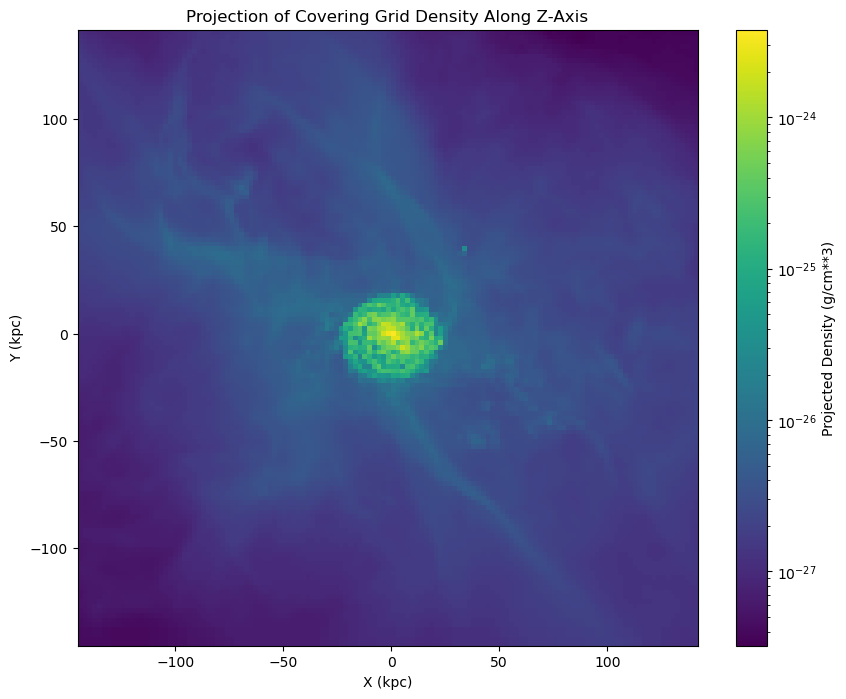

In [51]:
# Choose the axis to project along: 0 (x), 1 (y), or 2 (z)
projection_axis = 2  # For example, projecting along z-axis

# Extract the density field from the covering grid
cg_density = covering_grid["density"]
# Get the unit of the density field
density_unit = str(cg_density.units)
print("Covering Grid Density Unit:", density_unit)

# Sum (integrate) the density along the chosen axis
projected_density = np.sum(cg_density, axis=projection_axis)

# Calculate the physical bounds for the 2D projection
refinement_center_kpc = halo_center_kpc

right = refinement_right_edge_kpc - refinement_center_kpc
left = refinement_left_edge_kpc - refinement_center_kpc

# Define bounds dynamically based on the projection axis
if projection_axis == 0:  # x-axis projection
    x_bounds = [left[1], right[1]]  # y-dimension bounds
    y_bounds = [left[2], right[2]]  # z-dimension bounds
    axis_label = "X"
elif projection_axis == 1:  # y-axis projection
    x_bounds = [left[0], right[0]]  # x-dimension bounds
    y_bounds = [left[2], right[2]]  # z-dimension bounds
    axis_label = "Y"
elif projection_axis == 2:  # z-axis projection
    x_bounds = [left[0], right[0]]  # x-dimension bounds
    y_bounds = [left[1], right[1]]  # y-dimension bounds
    axis_label = "Z"
else:
    raise ValueError("Invalid projection_axis! Must be 0 (x), 1 (y), or 2 (z).")

# Create a 2D plot of the projection with a logarithmic color scale
plt.figure(figsize=(10, 8))
plt.imshow(
    projected_density.T,  # Transpose to match yt's coordinate system
    extent=[x_bounds[0], x_bounds[1], y_bounds[0], y_bounds[1]],
    origin="lower",
    aspect="auto",
    cmap="viridis",
    norm=LogNorm(vmin=projected_density[projected_density > 0].min(), vmax=projected_density.max()),  # Avoid log(0)
)
plt.colorbar(label=f"Projected Density ({density_unit})")
plt.xlabel(f"{'Y' if projection_axis == 0 else 'X'} (kpc)")
plt.ylabel(f"{'Z' if projection_axis == 0 else 'Y'} (kpc)")
plt.title(f"Projection of Covering Grid Density Along {axis_label}-Axis")
plt.show()


In [73]:
ds.field_list

[('all', 'creation_time'),
 ('all', 'dynamical_time'),
 ('all', 'metallicity_fraction'),
 ('all', 'particle_index'),
 ('all', 'particle_mass'),
 ('all', 'particle_position_x'),
 ('all', 'particle_position_y'),
 ('all', 'particle_position_z'),
 ('all', 'particle_type'),
 ('all', 'particle_velocity_x'),
 ('all', 'particle_velocity_y'),
 ('all', 'particle_velocity_z'),
 ('enzo', 'Cooling_Time'),
 ('enzo', 'Dark_Matter_Density'),
 ('enzo', 'Density'),
 ('enzo', 'Electron_Density'),
 ('enzo', 'GasEnergy'),
 ('enzo', 'Grav_Potential'),
 ('enzo', 'HII_Density'),
 ('enzo', 'HI_Density'),
 ('enzo', 'HeIII_Density'),
 ('enzo', 'HeII_Density'),
 ('enzo', 'HeI_Density'),
 ('enzo', 'Metal_Density'),
 ('enzo', 'Temperature'),
 ('enzo', 'TotalEnergy'),
 ('enzo', 'x-velocity'),
 ('enzo', 'y-velocity'),
 ('enzo', 'z-velocity'),
 ('io', 'creation_time'),
 ('io', 'dynamical_time'),
 ('io', 'metallicity_fraction'),
 ('io', 'particle_index'),
 ('io', 'particle_mass'),
 ('io', 'particle_position_x'),
 ('io'

In [74]:
gas_derived_fields = [field for field in ds.derived_field_list if field[0] == "gas"]
print("\nDerived Gas Fields:")
for field in gas_derived_fields:
    print(field)


Derived Gas Fields:
('gas', 'El_density')
('gas', 'El_fraction')
('gas', 'El_mass')
('gas', 'El_number_density')
('gas', 'H_density')
('gas', 'H_fraction')
('gas', 'H_mass')
('gas', 'H_nuclei_density')
('gas', 'H_number_density')
('gas', 'H_p0_density')
('gas', 'H_p0_fraction')
('gas', 'H_p0_mass')
('gas', 'H_p0_number_density')
('gas', 'H_p1_density')
('gas', 'H_p1_fraction')
('gas', 'H_p1_mass')
('gas', 'H_p1_number_density')
('gas', 'He_density')
('gas', 'He_fraction')
('gas', 'He_mass')
('gas', 'He_nuclei_density')
('gas', 'He_number_density')
('gas', 'He_p0_density')
('gas', 'He_p0_fraction')
('gas', 'He_p0_mass')
('gas', 'He_p0_number_density')
('gas', 'He_p1_density')
('gas', 'He_p1_fraction')
('gas', 'He_p1_mass')
('gas', 'He_p1_number_density')
('gas', 'He_p2_density')
('gas', 'He_p2_fraction')
('gas', 'He_p2_mass')
('gas', 'He_p2_number_density')
('gas', 'angular_momentum_magnitude')
('gas', 'angular_momentum_x')
('gas', 'angular_momentum_y')
('gas', 'angular_momentum_z')
('

In [97]:
def pos(x_id,y_id):


    x_coord = covering_grid['gas','x'][x_id][y_id].to('kpc') 
    x_pos = x_coord - halo_center_kpc[0]
    
    y_coord = covering_grid['gas','y'][x_id][y_id].to('kpc') 
    y_pos = y_coord - halo_center_kpc[1]

    z_coord = covering_grid['gas','z'][x_id][y_id].to('kpc') 
    z_pos = z_coord - halo_center_kpc[2]


    return x_pos,y_pos,z_pos

def vel(x_id,y_id):


    vx = covering_grid['gas','vx_corrected'][x_id][y_id] # km/s
    vy = covering_grid['gas','vy_corrected'][x_id][y_id] # km/s
    vz = covering_grid['gas','vz_corrected'][x_id][y_id] # km/s

    #radial velocity
    vr = covering_grid['gas','radial_velocity_corrected'][x_id][y_id] # km/s

    return vx,vy,vz,vr

x_id = 1
y_id = 1

xpos,ypos,zpos = pos(x_id,y_id)
vx,vy,vz,vr = vel(x_id,y_id)

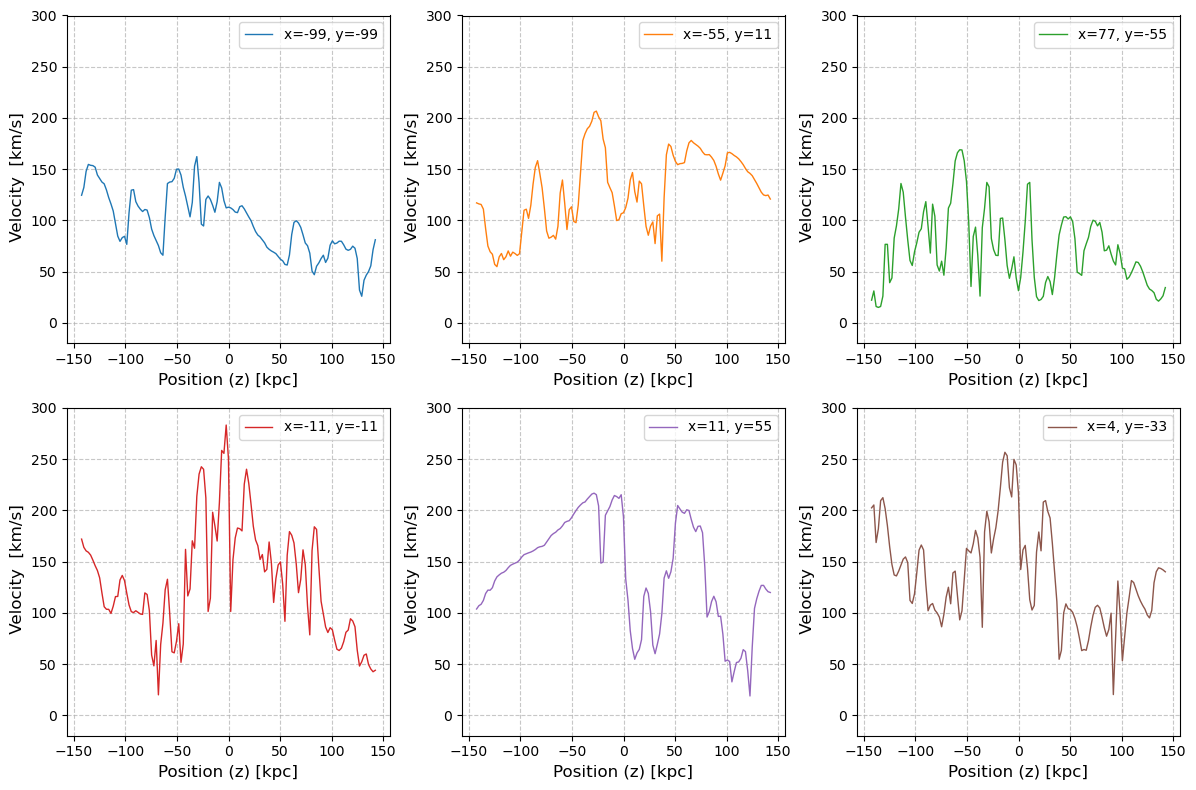

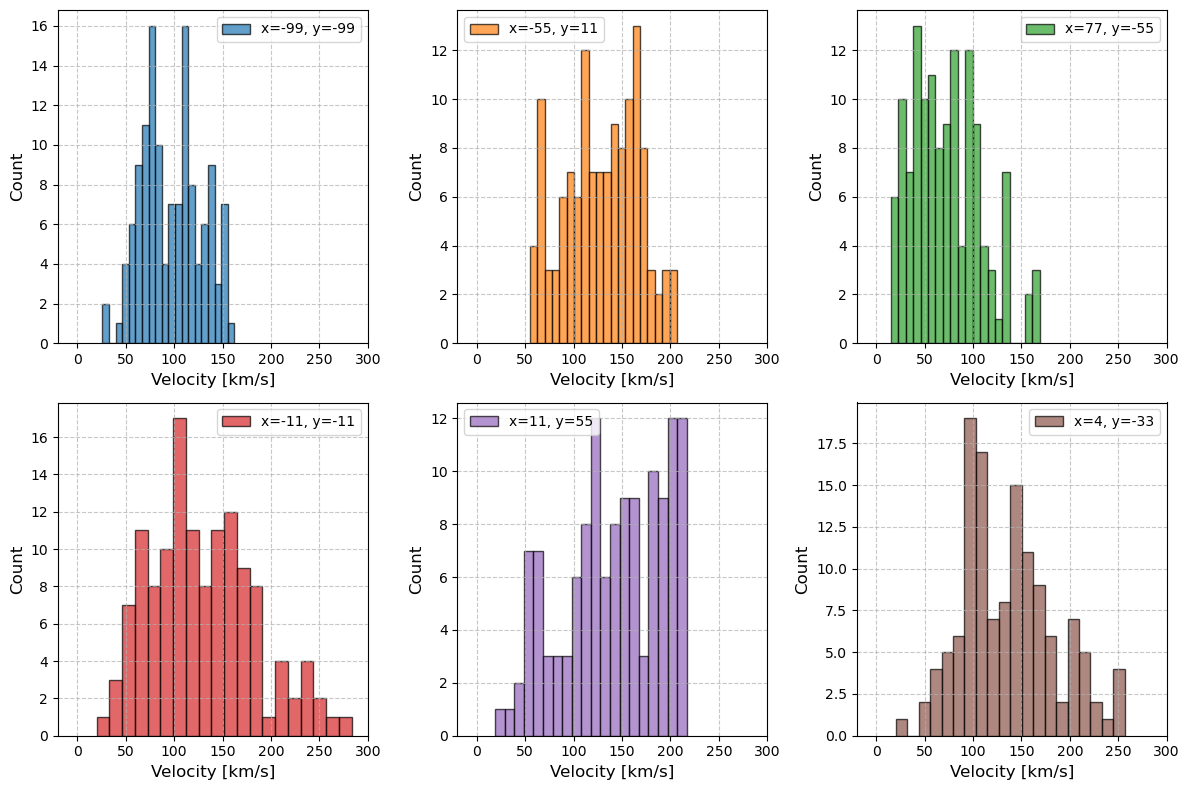

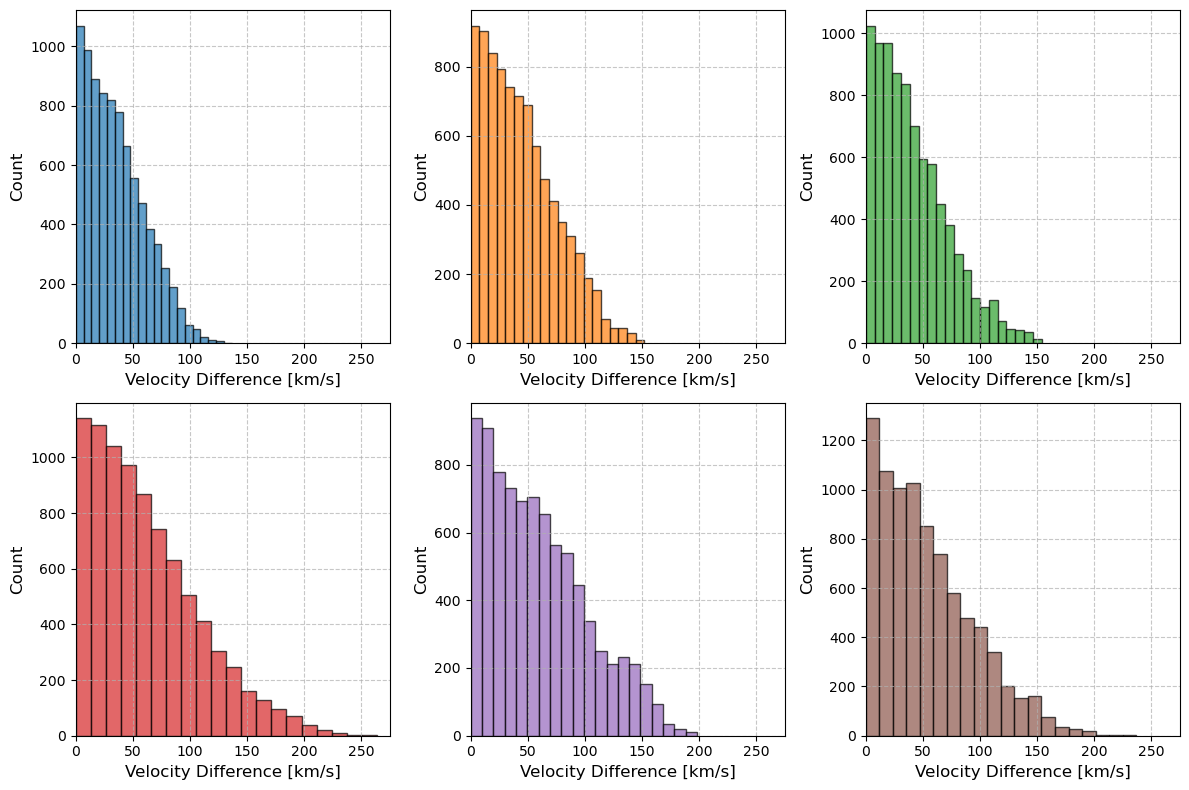

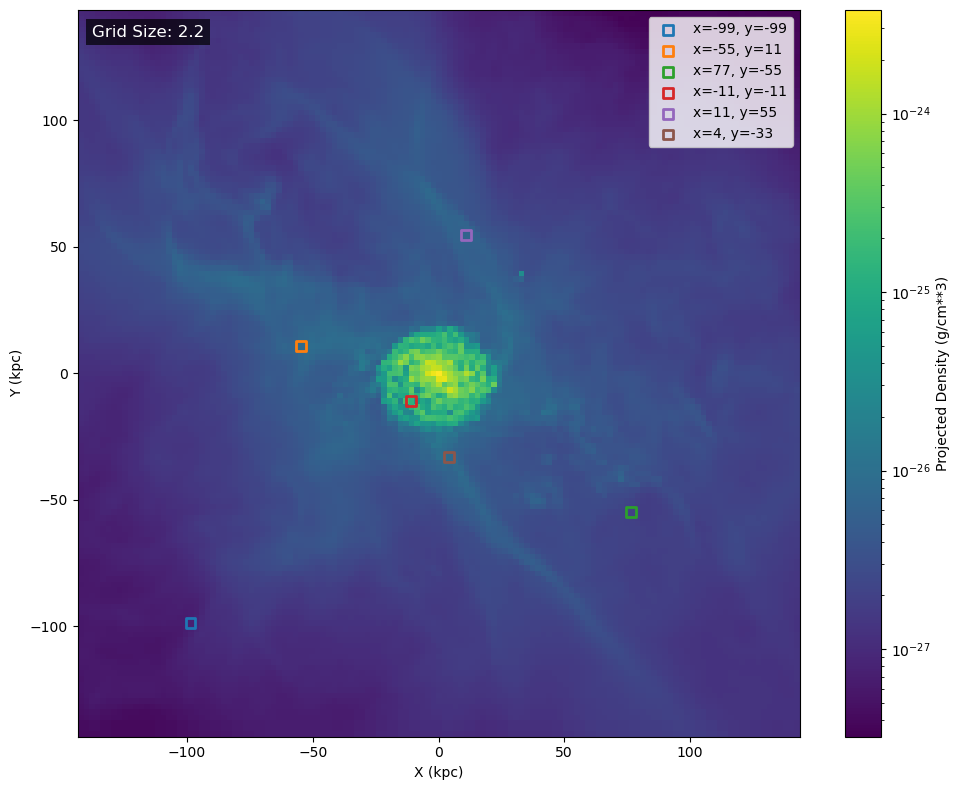

In [115]:
# List of x_id and y_id pairs to iterate over
x_id_list = [20,40, 100,60,70,67]
y_id_list = [20,70, 40,60,90,50]

# Colors for each line/square (optional: let matplotlib choose automatically)
colors = plt.cm.tab10(range(len(x_id_list)))

# Number of subplots
n_subplots = len(x_id_list)

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))  # Adjust grid size based on your preference
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Plot each velocity vs. position in a separate subplot
for i, (x_id, y_id) in enumerate(zip(x_id_list, y_id_list)):
    xpos, ypos, zpos = pos(x_id, y_id)
    vx, vy, vz,vr = vel(x_id, y_id)
    Velocity = np.sqrt(vx**2+vy**2+vz**2).to_value()   # Convert velocity to a numeric array for plotting if necessary
    
    xpos_value = xpos[0].to_value()
    ypos_value = ypos[0].to_value()
    
    # Plot on the respective subplot
    ax = axes[i]
    ax.plot(zpos, Velocity, linestyle='-', linewidth=1, color=colors[i], label=f"x={round(xpos_value)}, y={round(ypos_value)}")
    ax.set_xlabel("Position (z) [kpc]", fontsize=12)
    ax.set_ylabel(" Velocity  [km/s]", fontsize=12)
    ax.set_ylim(-20,300)
    ax.legend(fontsize=10)
    ax.grid(True, linestyle="--", alpha=0.7)

# Turn off unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
# Save and show the plot
plt.savefig(save_path + f'v_profiles.png')
plt.show()

#####################################################################histogram Plot#####################################################################

# Number of subplots
n_subplots = len(x_id_list)

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))  # Adjust grid size based on your preference
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Plot histogram of velocities in each subplot
for i, (x_id, y_id) in enumerate(zip(x_id_list, y_id_list)):
    xpos, ypos, zpos = pos(x_id, y_id)
    vx, vy, vz, vr = vel(x_id, y_id)
    Velocity = np.sqrt(vx**2+vy**2+vz**2).to_value()  # Convert velocity to a numeric array for plotting if necessary
    
    xpos_value = xpos[0].to_value()
    ypos_value = ypos[0].to_value()
    
    # Plot histogram on the respective subplot
    ax = axes[i]
    ax.hist(Velocity, bins=20, color=plt.cm.tab10(i), alpha=0.7, edgecolor='black', label=f"x={round(xpos_value)}, y={round(ypos_value)}")
    ax.set_xlabel("Velocity [km/s]", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    ax.set_xlim(-20,300)
    ax.legend(fontsize=10)
    ax.grid(True, linestyle="--", alpha=0.7)

# Turn off unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
# Save and show the plot
plt.savefig(save_path + f'v_histograms.png')
plt.show()

#####################################################################Velocity difference Plot#####################################################################
# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))  # Adjust grid size based on your preference
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Loop through each grid point to compute and plot velocity differences
for i, (x_id, y_id) in enumerate(zip(x_id_list, y_id_list)):
    # Get position and velocity data for the grid point
    xpos, ypos, zpos = pos(x_id, y_id)
    vx, vy, vz, vr = vel(x_id, y_id)
    
    # Compute velocity magnitudes
    Velocity = np.sqrt(vx**2 + vy**2 + vz**2).to_value()  # Convert to numerical values if necessary
    
    # Compute differences between all pairs of velocities
    Velocity_diff = [
        abs(Velocity[j] - Velocity[k])
        for j in range(len(Velocity)) for k in range(j + 1, len(Velocity))
    ]
    
    # Plot histogram of velocity differences
    ax = axes[i]
    ax.hist(Velocity_diff, bins=20, color=colors[i], alpha=0.7, edgecolor='black')
    ax.set_xlabel("Velocity Difference [km/s]", fontsize=12)
    ax.set_xlim(0,275)
    ax.set_ylabel("Count", fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.7)

# Turn off unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Save and show the plot
plt.savefig(save_path + 'velocity_differences_histograms.png')
plt.show()



#####################################################################Projection Plot#####################################################################
# Extract the density field from the covering grid
cg_density = covering_grid["density"]
density_unit = str(cg_density.units)

# Sum (integrate) the density along the chosen axis
projected_density = np.sum(cg_density, axis=2)

# Calculate bounds
refinement_center_kpc = halo_center_kpc
right = refinement_right_edge_kpc - refinement_center_kpc
left = refinement_left_edge_kpc - refinement_center_kpc
x_bounds = [left[1], right[0]]
y_bounds = [left[1], right[1]]

# Create the projection plot
plt.figure(figsize=(10, 8))
plt.imshow(
    projected_density.T,
    extent=[x_bounds[0], x_bounds[1], y_bounds[0], y_bounds[1]],
    origin="lower",
    aspect="auto",
    cmap="viridis",
    norm=LogNorm(vmin=projected_density[projected_density > 0].min(), vmax=projected_density.max()),
)
plt.colorbar(label=f"Projected Density ({density_unit})")
plt.xlabel("X (kpc)")
plt.ylabel("Y (kpc)")

# Annotate positions on the projection plot
for i, (x_id, y_id) in enumerate(zip(x_id_list, y_id_list)):
    xpos, ypos, _ = pos(x_id, y_id)
    xpos_value = xpos[0].to_value()
    ypos_value = ypos[0].to_value()

    # Add a square at the position, matching the line color
    plt.scatter(
        xpos_value, ypos_value, 
        s=50, marker='s', facecolors='none', edgecolors=colors[i], linewidths=2, 
        label=f"x={round(xpos_value)}, y={round(ypos_value)}"
    )

# Annotate grid size on the top-left corner

plt.text(
    x_bounds[0] + 0.02 * (x_bounds[1] - x_bounds[0]),  # Shift right by 5% of the plot width
    y_bounds[1] - 0.02 * (y_bounds[1] - y_bounds[0]),
    f"Grid Size: {round(float(Grid_size[0]), 1)}", 
    fontsize=12, color="white", backgroundcolor="black", 
    ha="left", va="top", bbox=dict(facecolor="black", edgecolor="none", alpha=0.7)
)

# Add a legend for the annotated points
plt.legend(fontsize=10, loc='upper right')
plt.tight_layout()
plt.savefig(save_path + f'grid_projection.png')
plt.show()

